<a href="https://colab.research.google.com/github/Viroslav/DLS_2-NLP-/blob/main/seminars/neural_text_classification_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение классификатора с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

  0%|          | 0/25000 [00:00<?, ?it/s]

In [9]:
words

Counter({'i': 75732,
         'rented': 337,
         'am': 2769,
         'curiousyellow': 3,
         'from': 20392,
         'my': 12443,
         'video': 1547,
         'store': 477,
         'because': 8990,
         'of': 145326,
         'all': 23156,
         'the': 334696,
         'controversy': 49,
         'that': 69353,
         'surrounded': 133,
         'it': 77109,
         'when': 14087,
         'was': 48008,
         'first': 8857,
         'released': 944,
         'in': 93028,
         '1967': 46,
         'also': 9073,
         'heard': 1094,
         'at': 23360,
         'seized': 10,
         'by': 22365,
         'us': 3920,
         'customs': 34,
         'if': 16606,
         'ever': 5804,
         'tried': 760,
         'to': 135042,
         'enter': 193,
         'this': 75190,
         'country': 838,
         'therefore': 332,
         'being': 6570,
         'a': 161941,
         'fan': 1848,
         'films': 7727,
         'considered': 482,
     

In [10]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>']) # добавим спец токены
counter_threshold = 25 # порог вхождения слов в словаре (встречается более 25 раз в тексте)

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [11]:
len(vocab)

11399

In [12]:
# маппинг из индексов в слова и наоборот
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # берём токен по idx, от него ['text']
        # нижний регистр, удаление пунктуации
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))

        # добавим сначала токен <bos>
        tokenized_sentence = [self.bos_id]
        # достаём id слова, если его нет, подставляем <unk>
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        # в конце добавляем <eos>
        tokenized_sentence += [self.eos_id]

        # словарь с текстом и лэйблом
        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:

    # считаем длину всех текстов в баче
    seq_lens = [len(x['text']) for x in input_batch]

    # ограничиваем длину либо 256, либо самой длинной последовательностью
    max_seq_len = min(max(seq_lens), max_len)

    # формируем батч
    new_batch = []
    for sequence in input_batch:
        # если текст короче, добавляем <pad>
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    # собираем весь батч в Тензор (т.к. у нас только индексы, используем LongTensor)
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [16]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Архитектура модели

In [17]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__() # наследуем метод init от nn.Module
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)  # batch_first - размер батча, - первая размерность
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        # считаем эмбеддинги (сначала это вектор длины seq_len, потом матрица на количество скрытых слоёв)
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim] - ТЕНЗОР

        # на выходе у нас два Тензора: output, h_n
        # output - [batch_size, seq_len, D * hidden_size], D = 1, если LSTM, D=2, если biLSTM
        # output содержить h_t(y_t) - выходные фичи после применения RNN
        # h_n - [D * num_layers, hidden_size] - содержит финальное скрытое состояние для каждого элемента батча
        output, h_n = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]


        # Для разных типов аггрегации эмбеддингов
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

## Train loop

In [18]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            # берём тут просто индекс с максимальным значением логита
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()  # item() - переведёт на CPU + вернёт число, а не тензор

    return accuracy

In [19]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>']) # CEL принимает логиты, игнорируя <pad> токен
optimizer = torch.optim.Adam(model.parameters())

In [20]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

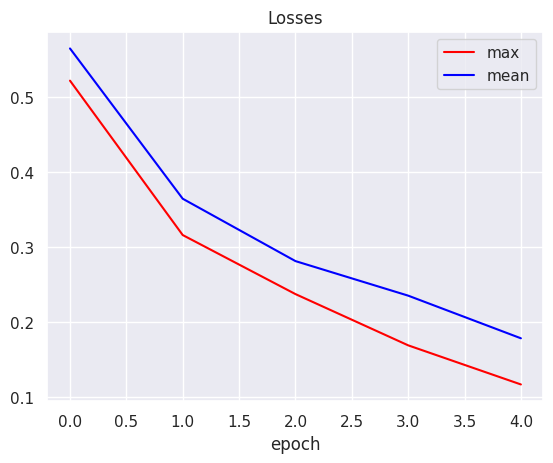

In [21]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 85.50
Лучшая accuracy для подхода mean: 86.40


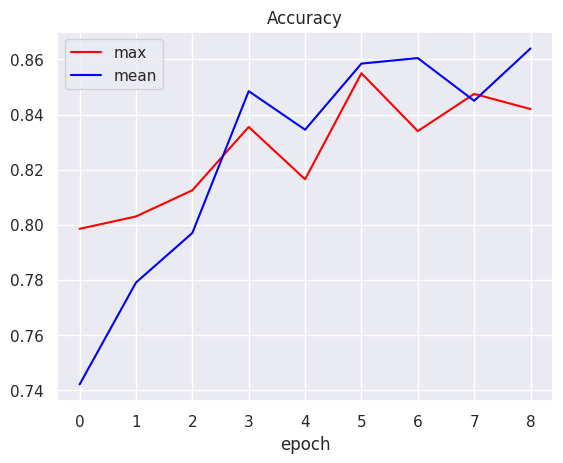

In [22]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()